In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import catboost as cb
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [5]:
train.shape

(230130, 6)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [7]:
counts = train.groupby(["country","store","product"])["id"].count().rename('num_rows').reset_index()
display(counts)
counts_val_counts = counts["num_rows"].value_counts().rename("Count").reset_index().rename(columns={"index": "length"})
display(counts_val_counts)

,country,store,product,num_rows
0,Canada,Discount Stickers,Holographic Goose,2557
1,Canada,Discount Stickers,Kaggle,2557
2,Canada,Discount Stickers,Kaggle Tiers,2557
3,Canada,Discount Stickers,Kerneler,2557
4,Canada,Discount Stickers,Kerneler Dark Mode,2557
...,...,...,...,...
85,Singapore,Stickers for Less,Holographic Goose,2557
86,Singapore,Stickers for Less,Kaggle,2557
87,Singapore,Stickers for Less,Kaggle Tiers,2557
88,Singapore,Stickers for Less,Kerneler,2557


,num_rows,Count
0,2557,90


In [8]:
train['num_sold'].isna().sum()

8871

In [9]:
train = train.dropna().reset_index(drop=True)

In [10]:
counts = train.groupby(["country","store","product"])["num_sold"].count().rename("num_rows")
missing_data = counts.loc[counts != 2557]
missing_data_df = missing_data.reset_index()
missing_data_df["num_missing_rows"] = 2557 - missing_data_df["num_rows"]
missing_data_df

,country,store,product,num_rows,num_missing_rows
0,Canada,Discount Stickers,Kerneler,2556,1
1,Canada,Premium Sticker Mart,Holographic Goose,2177,380
2,Canada,Stickers for Less,Holographic Goose,1249,1308
3,Kenya,Discount Stickers,Kerneler,2494,63
4,Kenya,Discount Stickers,Kerneler Dark Mode,2556,1
5,Kenya,Premium Sticker Mart,Holographic Goose,1911,646
6,Kenya,Stickers for Less,Holographic Goose,1199,1358


In [11]:
# train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
# test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

# train['day_of_week'] = pd.to_datetime(train['date']).dt.dayofweek
# train['month'] = pd.to_datetime(train['date']).dt.month
# train['year'] = pd.to_datetime(train['date']).dt.year
# train['is_weekend'] = train['day_of_week'].isin([5, 6])

# test['day_of_week'] = pd.to_datetime(test['date']).dt.dayofweek
# test['month'] = pd.to_datetime(test['date']).dt.month
# test['year'] = pd.to_datetime(test['date']).dt.year
# test['is_weekend'] = test['day_of_week'].isin([5, 6])

print(min(train['date']), max(train['date']))

def feature_engineering(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter.astype('float64')
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype('float64')
    df['hour'] = df['date'].dt.hour.astype('float64')
    df['minute'] = df['date'].dt.minute.astype('float64')
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['sine_day'] = np.sin(2 * np.pi * df['day'] / 365)
    df['cos_day'] = np.cos(2 * np.pi * df['day'] / 365)
    df['sine_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['sine_year'] = np.sin(2 * np.pi * df['year']/7)
    df['cos_year'] = np.cos(2 * np.pi * df['year']/7)
    df['group'] = (df['year'] - 2010) * 48 + df['month'] * 4 + df['day'] // 7

feature_engineering(train)
feature_engineering(test)

2010-01-01 2016-12-31


In [12]:
pd.set_option("display.max_columns", None)
# train = train.set_index('date')

In [13]:
train.head(10)

,id,date,country,store,product,num_sold,year,quarter,month,week,day,day_of_week,week_of_year,hour,minute,is_weekend,sine_day,cos_day,sine_month,cos_month,sine_year,cos_year,group
0,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
1,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
2,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
3,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
4,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
5,6,2010-01-01,Canada,Stickers for Less,Kaggle,1837.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
6,7,2010-01-01,Canada,Stickers for Less,Kaggle Tiers,1659.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
7,8,2010-01-01,Canada,Stickers for Less,Kerneler,807.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
8,9,2010-01-01,Canada,Stickers for Less,Kerneler Dark Mode,940.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
9,10,2010-01-01,Canada,Premium Sticker Mart,Holographic Goose,375.0,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4


In [14]:
train.isna().sum()

id              0
date            0
country         0
store           0
product         0
num_sold        0
year            0
quarter         0
month           0
week            0
day             0
day_of_week     0
week_of_year    0
hour            0
minute          0
is_weekend      0
sine_day        0
cos_day         0
sine_month      0
cos_month       0
sine_year       0
cos_year        0
group           0
dtype: int64

In [15]:
agg_df = train.groupby(['date', 'store', 'product']).agg({'num_sold' : 'sum'}).reset_index().sort_values(['date', 'store', 'product'])
agg_df

,date,store,product,num_sold
0,2010-01-01,Discount Stickers,Holographic Goose,671.0
1,2010-01-01,Discount Stickers,Kaggle,5231.0
2,2010-01-01,Discount Stickers,Kaggle Tiers,4616.0
3,2010-01-01,Discount Stickers,Kerneler,2391.0
4,2010-01-01,Discount Stickers,Kerneler Dark Mode,2762.0
...,...,...,...,...
38350,2016-12-31,Stickers for Less,Holographic Goose,1656.0
38351,2016-12-31,Stickers for Less,Kaggle,10010.0
38352,2016-12-31,Stickers for Less,Kaggle Tiers,8312.0
38353,2016-12-31,Stickers for Less,Kerneler,4470.0


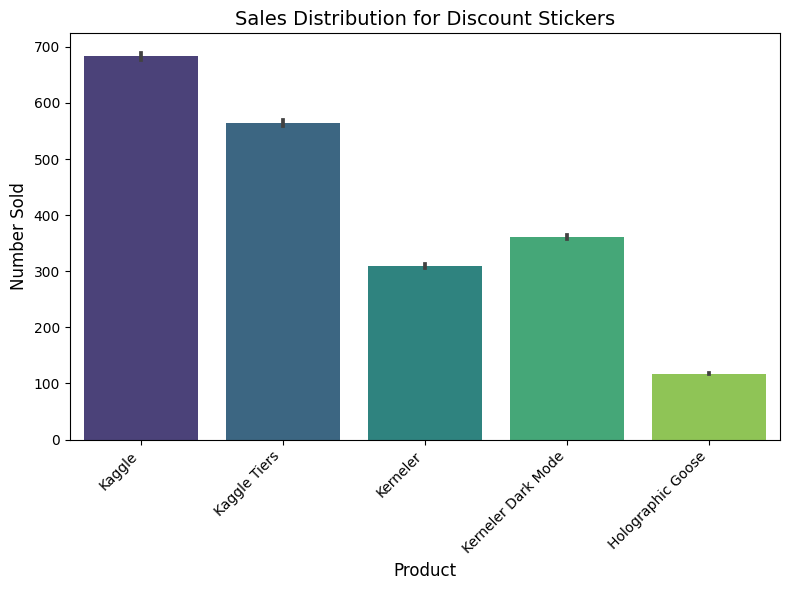

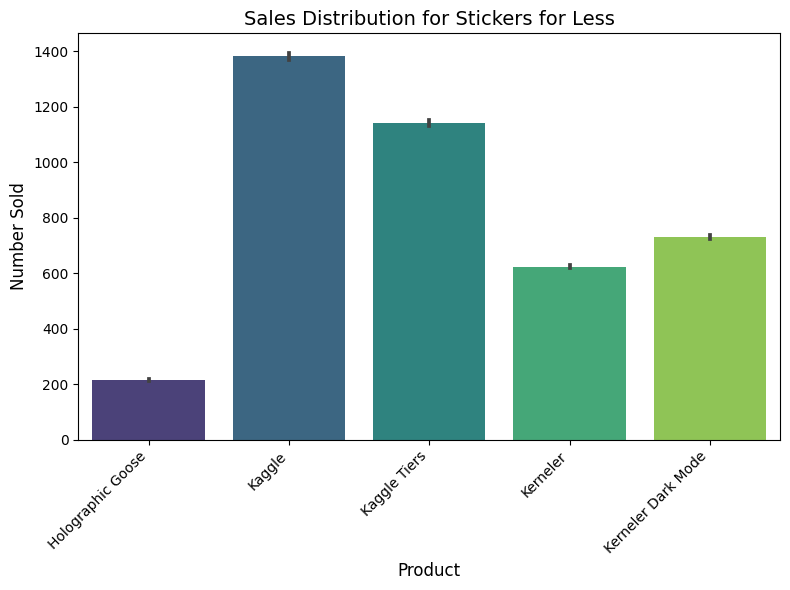

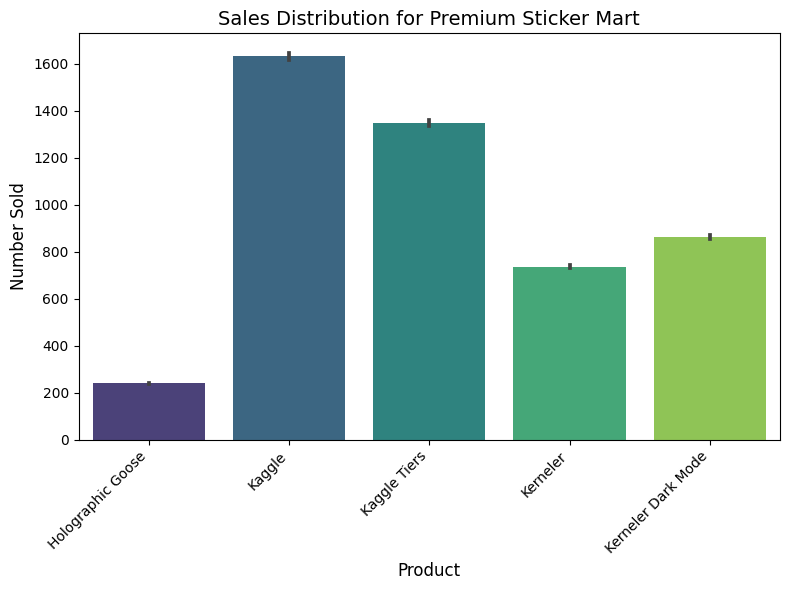

In [16]:
stores = train['store'].unique()

for store in stores:
    store_data = train[train['store'] == store]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(data=store_data, x='product', y='num_sold', palette='viridis')
    plt.title(f'Sales Distribution for {store}', fontsize=14)
    plt.xlabel('Product', fontsize=12)
    plt.ylabel('Number Sold', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Kaggle Stickers have the most sales across all stores

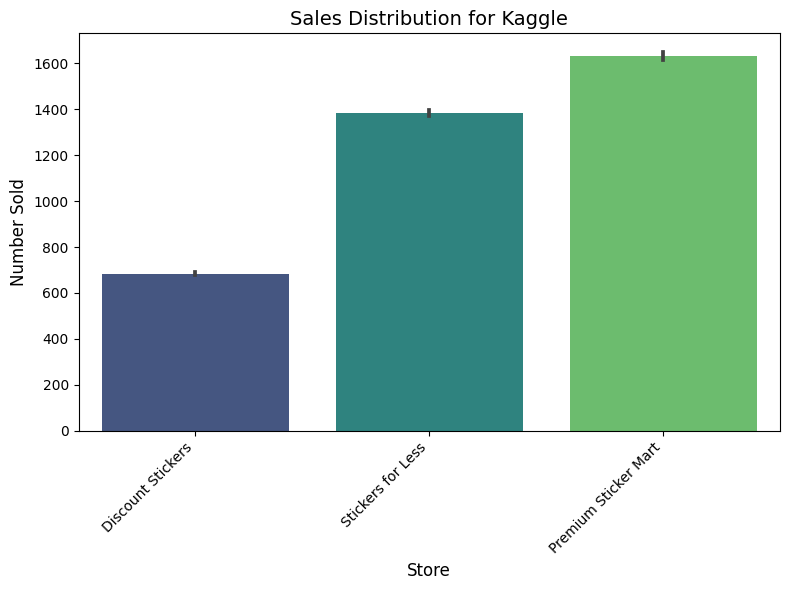

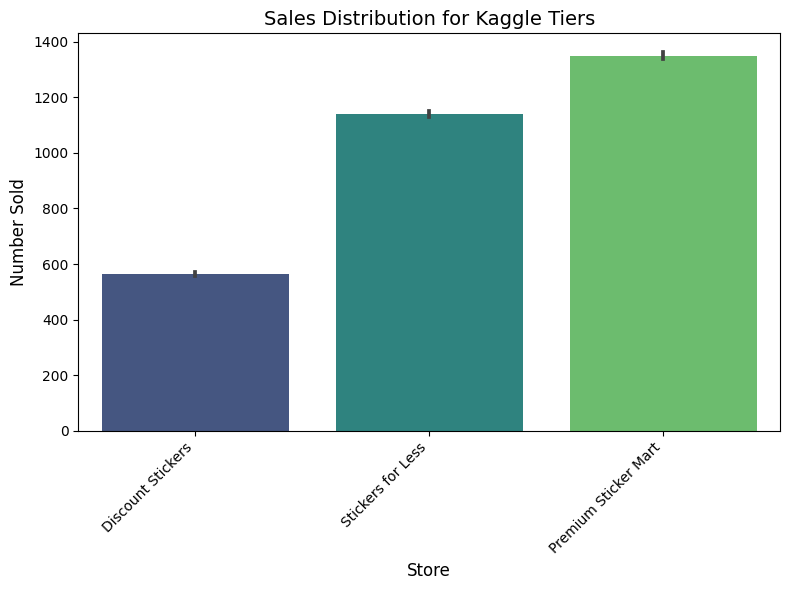

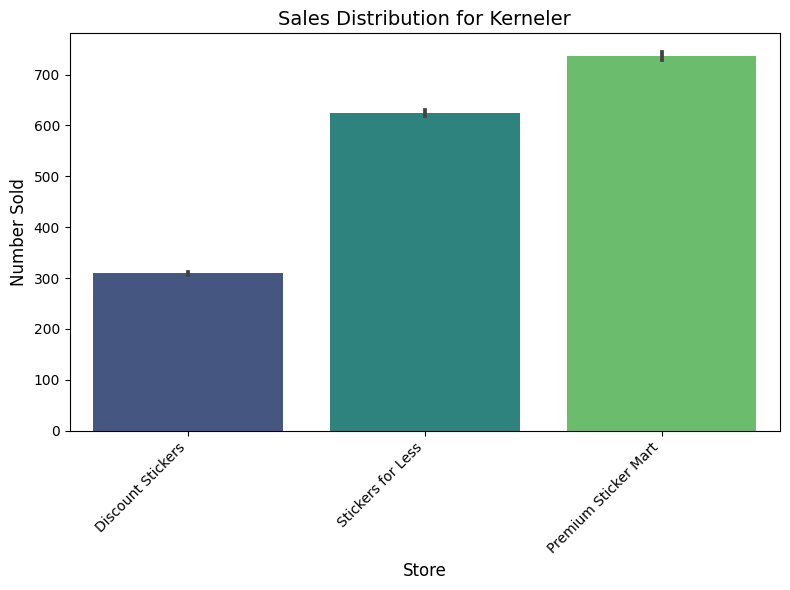

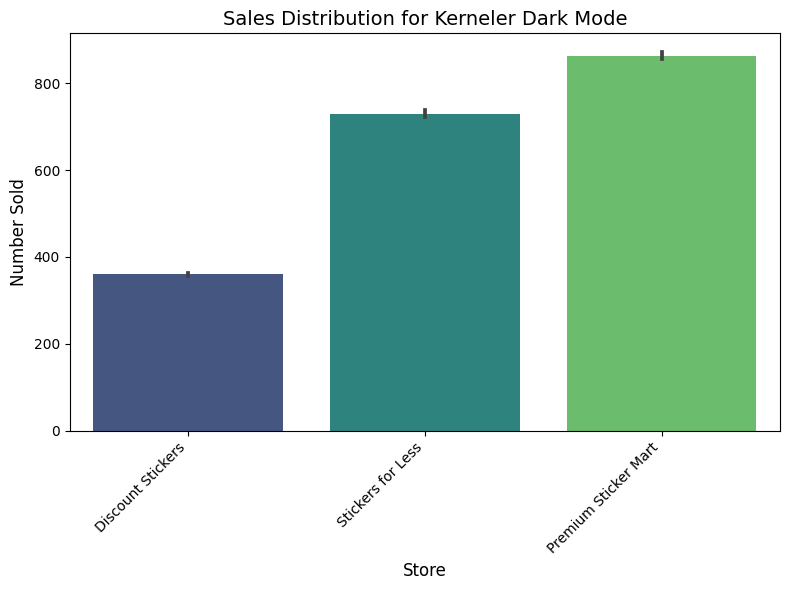

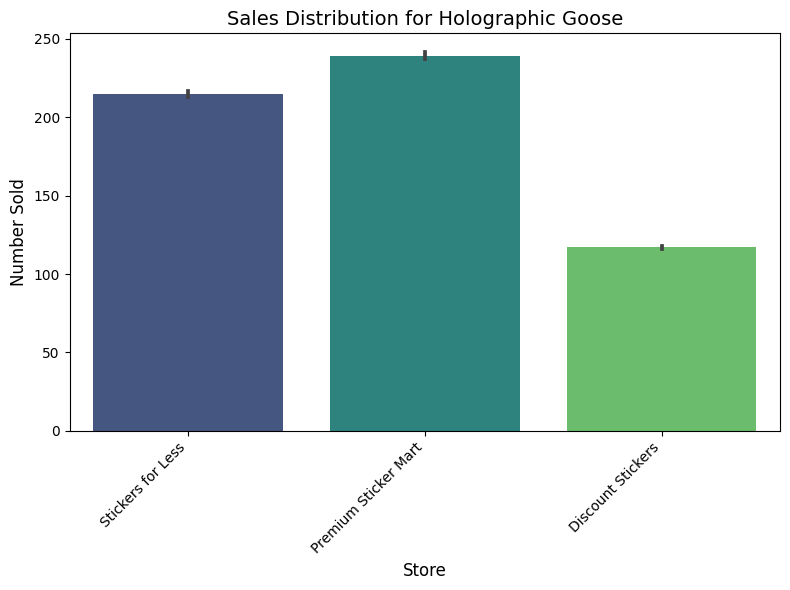

In [17]:
products = train['product'].unique()

for product in products:
    product_data = train[train['product'] == product]
    
    plt.figure(figsize=(8, 6))
    sns.barplot(data=product_data, x='store', y='num_sold', palette='viridis')
    plt.title(f'Sales Distribution for {product}', fontsize=14)
    plt.xlabel('Store', fontsize=12)
    plt.ylabel('Number Sold', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

<Axes: title={'center': 'Daily Sales Trends'}, xlabel='date'>

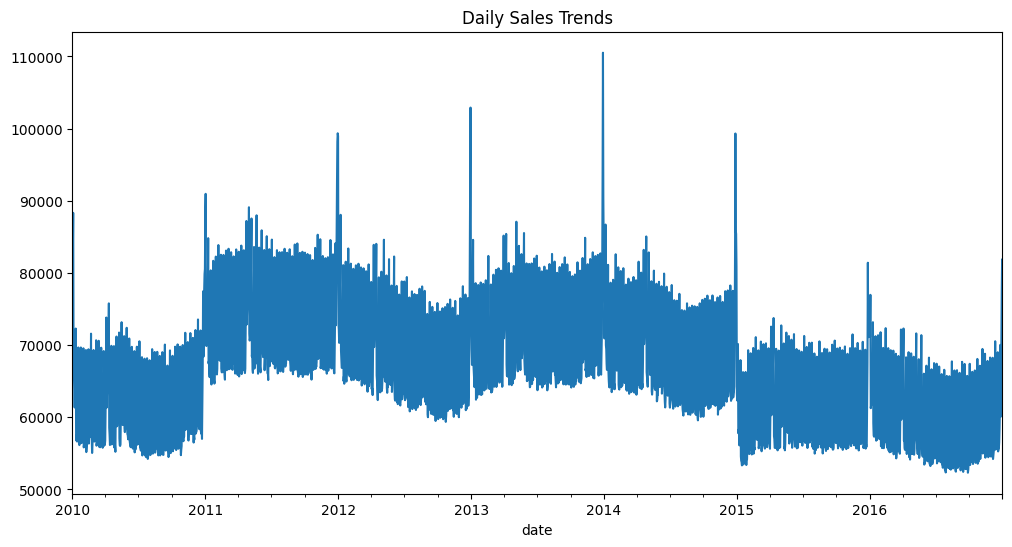

In [18]:
daily_sales = train.groupby('date')['num_sold'].sum()
daily_sales.plot(figsize=(12, 6), title='Daily Sales Trends')

Sales peak at around the new year time

<Axes: title={'center': 'Average Sales by Day of the Week'}, xlabel='day_of_week'>

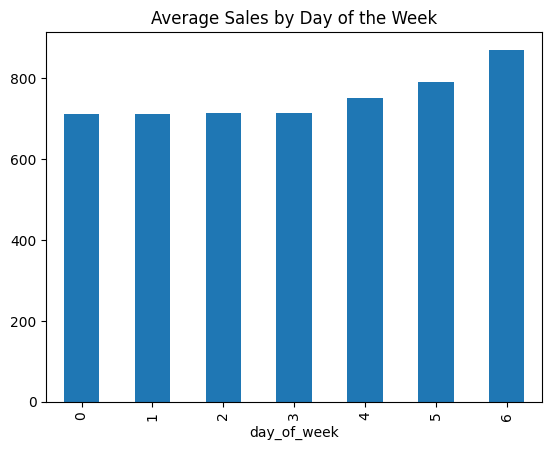

In [19]:
weekly_sales = train.groupby('day_of_week')['num_sold'].mean()
weekly_sales.plot(kind='bar', title='Average Sales by Day of the Week')

<Axes: title={'center': 'Average Sales by Month'}, xlabel='month'>

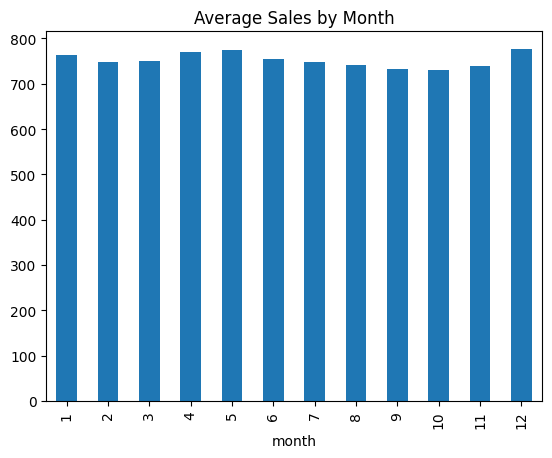

In [20]:
monthly_sales = train.groupby('month')['num_sold'].mean()
monthly_sales.plot(kind='bar', title='Average Sales by Month')

<Axes: title={'center': 'Yearly Sales Trends'}, xlabel='year'>

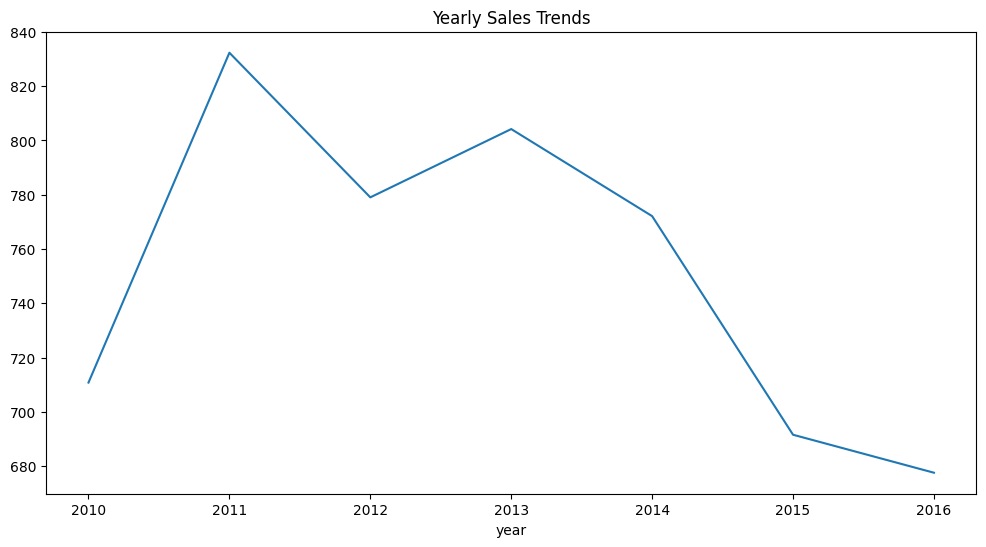

In [21]:
yearly_sales = train.groupby('year')['num_sold'].mean()
yearly_sales.plot(figsize=(12, 6), title='Yearly Sales Trends')

<Axes: title={'center': 'Weekend vs Weekday Sales'}, xlabel='is_weekend'>

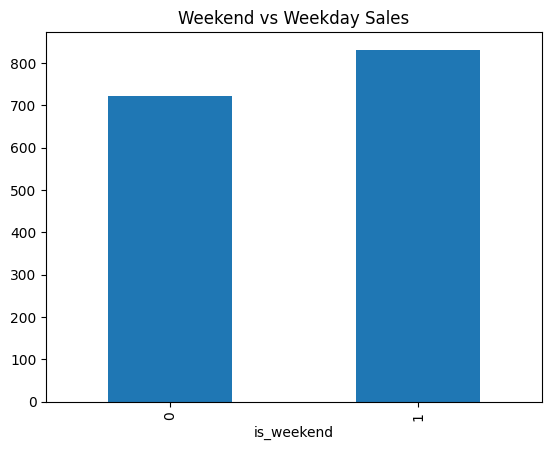

In [22]:
weekend_sales = train.groupby('is_weekend')['num_sold'].mean()
weekend_sales.plot(kind='bar', title='Weekend vs Weekday Sales')

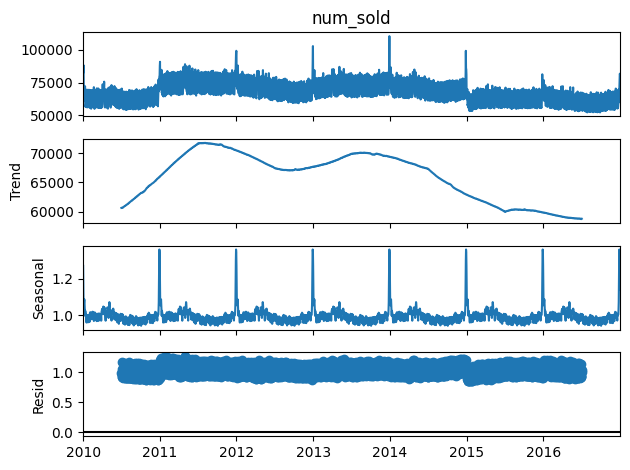

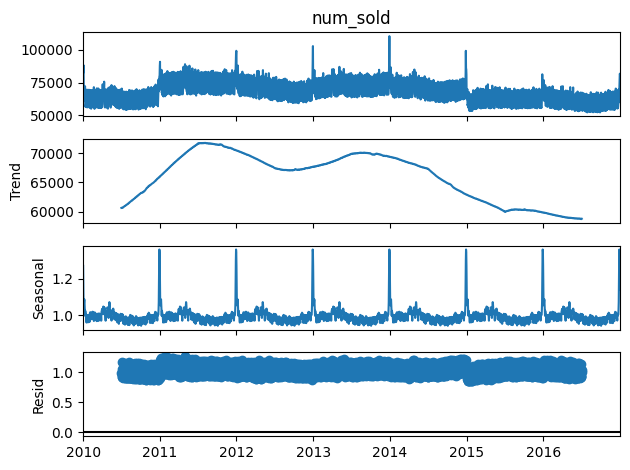

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(daily_sales, model='multiplicative', period=365)
result.plot()

In [24]:
total_sales = agg_df.pivot(index='date',columns=['store', 'product'], values='num_sold')
total_sales.head()

store      Discount Stickers                                                   \
product    Holographic Goose  Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode   
date                                                                            
2010-01-01             671.0  5231.0       4616.0   2391.0             2762.0   
2010-01-02             654.0  5000.0       4502.0   2393.0             2612.0   
2010-01-03             696.0  5498.0       4677.0   2523.0             2811.0   
2010-01-04             555.0  3955.0       3781.0   1830.0             2293.0   
2010-01-05             510.0  4174.0       3516.0   1748.0             2111.0   

store      Premium Sticker Mart                                 \
product       Holographic Goose   Kaggle Kaggle Tiers Kerneler   
date                                                             
2010-01-01               1955.0  12395.0      10976.0   5883.0   
2010-01-02               1897.0  11877.0      10848.0   5345.0   
2010-01-03               2010.0  13330.0      11778.0   5928.0   
2010-01-04               1555.0   9807.0       8970.0   4466.0   
2010-01-05               1549.0   9203.0       8519.0   4322.0   

store                         Stickers for Less                        \
product    Kerneler Dark Mode Holographic Goose   Kaggle Kaggle Tiers   
date                                                                    
2010-01-01             6774.0            1724.0  10599.0       9364.0   
2010-01-02             6519.0            1542.0  10568.0       8679.0   
2010-01-03             6992.0            1703.0  10779.0       9139.0   
2010-01-04             5435.0            1362.0   8406.0       7428.0   
2010-01-05             5135.0            1273.0   8209.0       7289.0   

store                                   
product    Kerneler Kerneler Dark Mode  
date                                    
2010-01-01   4786.0             5439.0  
2010-01-02   4461.0             5651.0  
2010-01-03   4764.0             5700.0  
2010-01-04   3724.0             4508.0  
2010-01-05   3616.0             4539.0

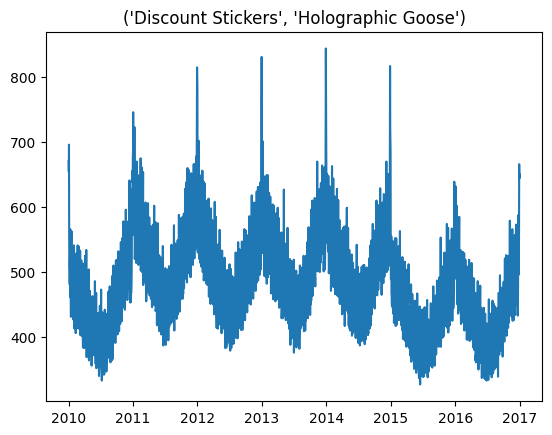

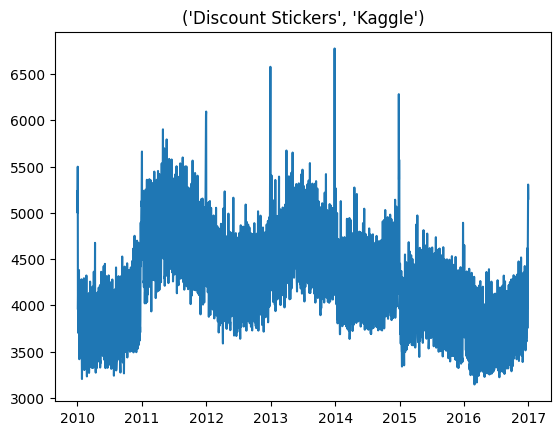

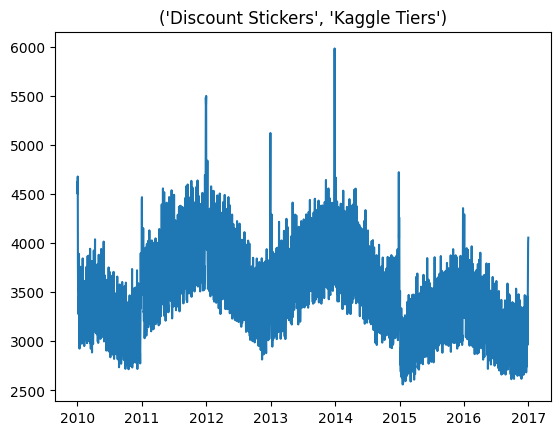

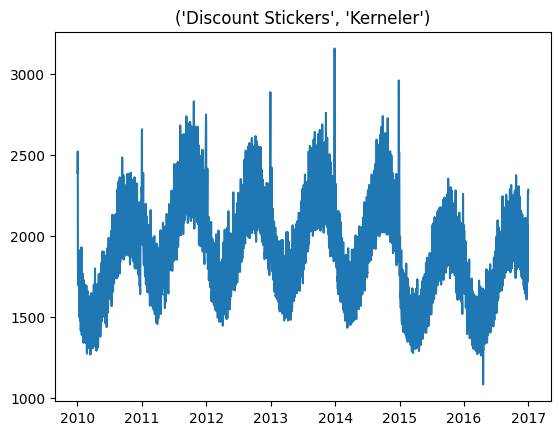

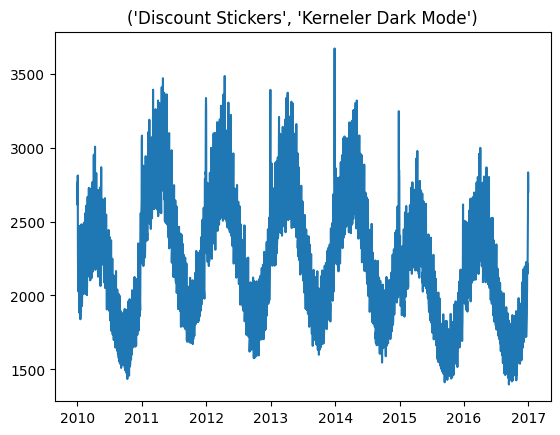

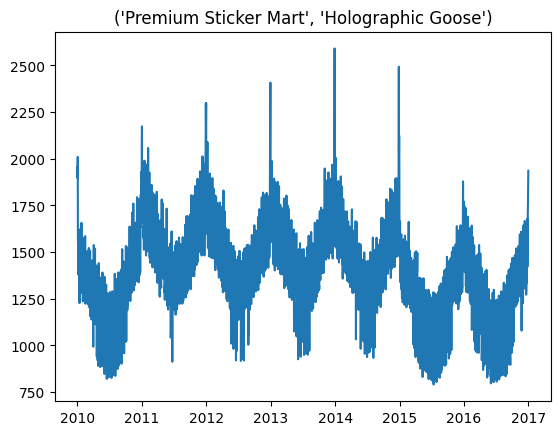

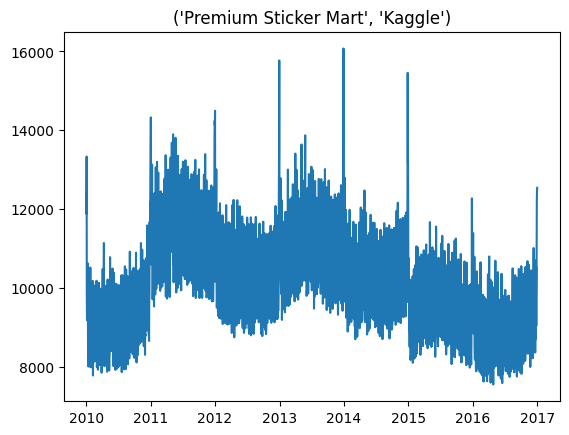

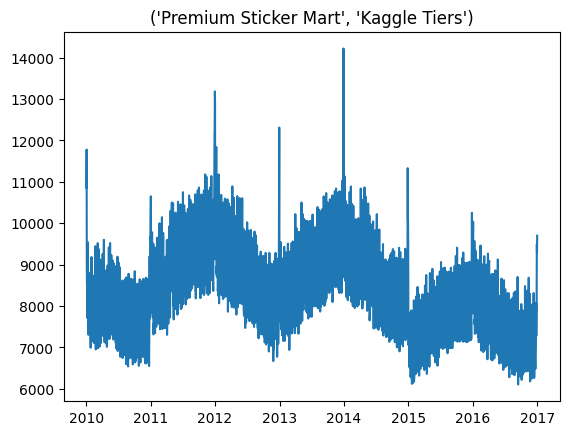

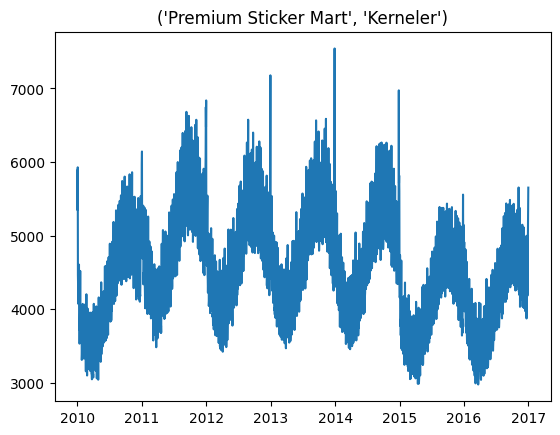

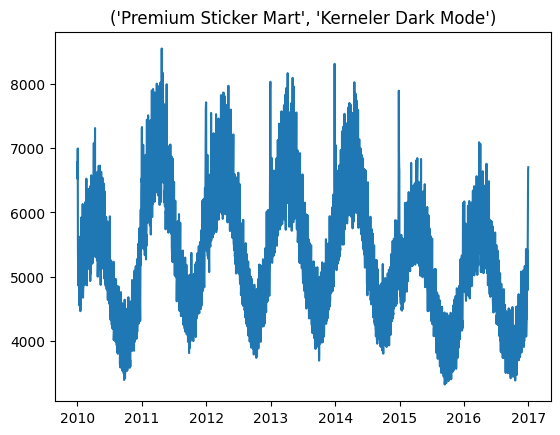

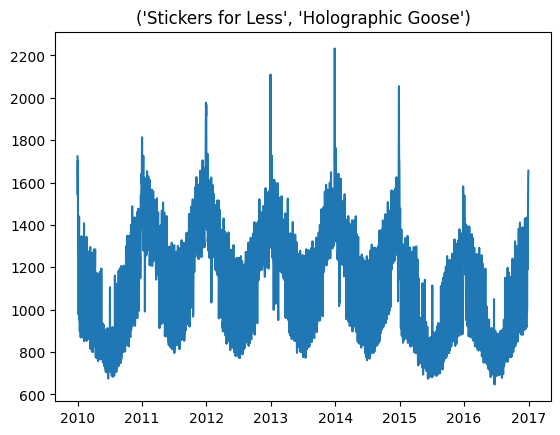

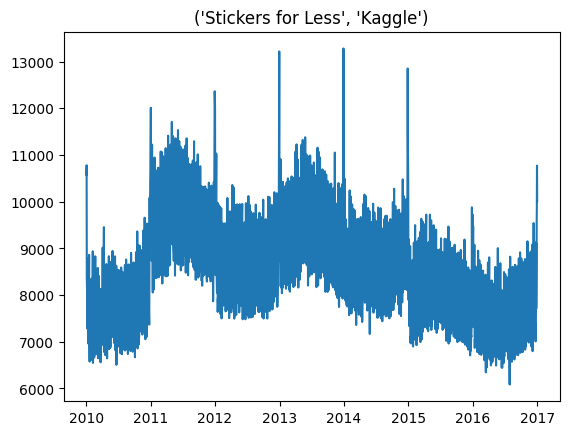

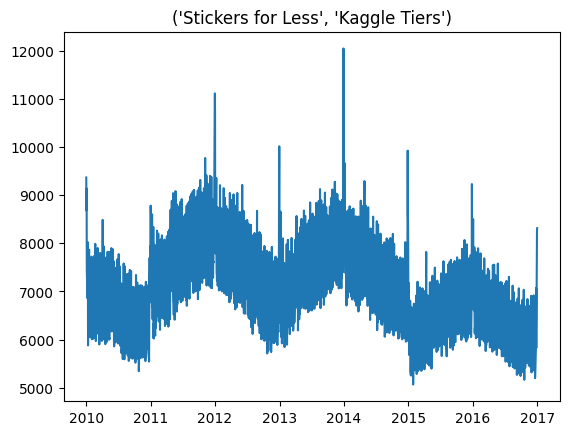

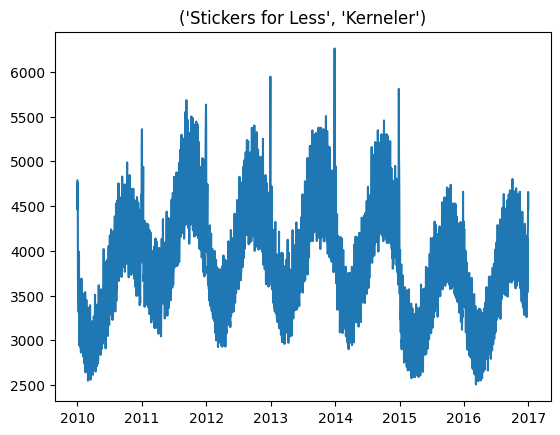

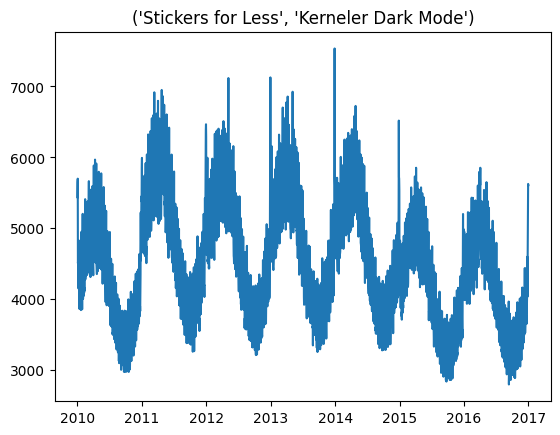

In [25]:
for col in total_sales.columns:
    plt.plot(total_sales[col])
    plt.title(col)
    plt.show()

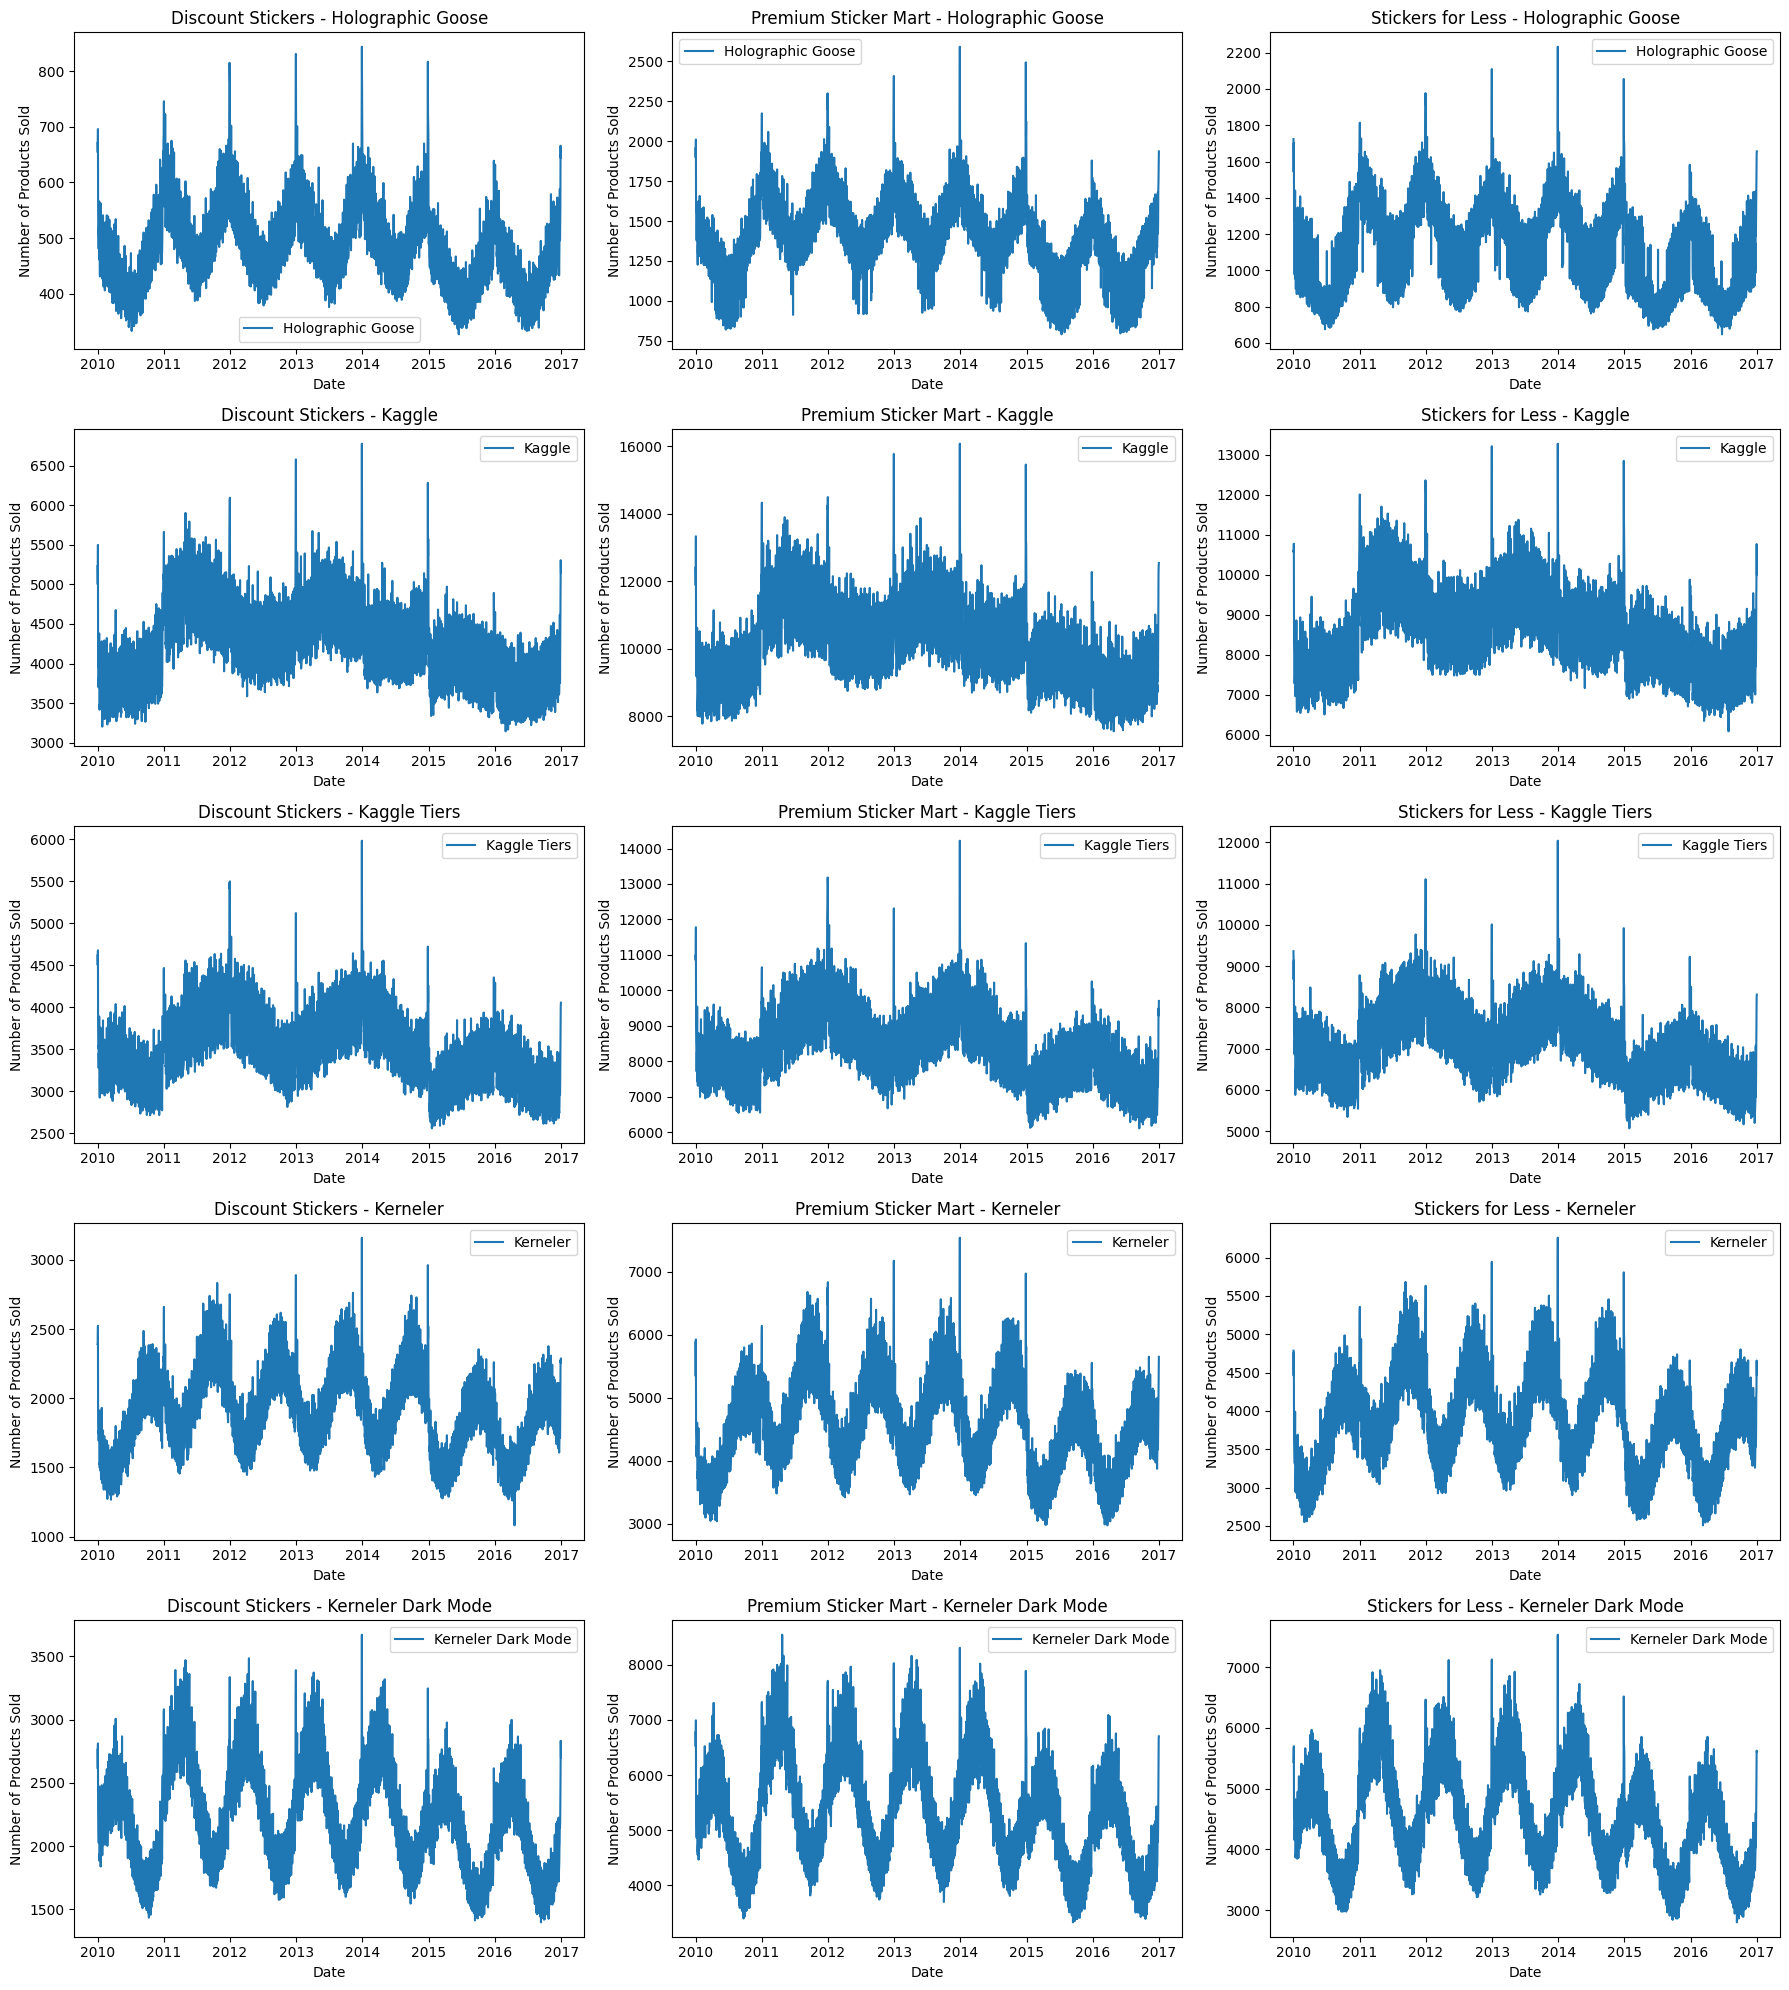

In [26]:
stores = total_sales.columns.get_level_values(0).unique()
products = total_sales.columns.get_level_values(1).unique()

fig, axes = plt.subplots(nrows=len(products), ncols=len(stores), figsize=(18, 20))

if len(stores) == 1:
    axes = [axes]
if len(products) == 1:
    axes = [axes]

for i, store in enumerate(stores):
    for j, product in enumerate(products):
        ax = axes[j][i]
        ax.plot(total_sales.index, total_sales[(store, product)], label=f"{product}")
        ax.set_title(f"{store} - {product}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Number of Products Sold")
        ax.legend()

plt.tight_layout()
plt.show()

In [27]:
def missing_data(input_data):
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

missing_data(total_sales)

Total  Percent    Types
store                product                                    
Discount Stickers    Holographic Goose       0      0.0  float64
                     Kaggle                  0      0.0  float64
                     Kaggle Tiers            0      0.0  float64
                     Kerneler                0      0.0  float64
                     Kerneler Dark Mode      0      0.0  float64
Premium Sticker Mart Holographic Goose       0      0.0  float64
                     Kaggle                  0      0.0  float64
                     Kaggle Tiers            0      0.0  float64
                     Kerneler                0      0.0  float64
                     Kerneler Dark Mode      0      0.0  float64
Stickers for Less    Holographic Goose       0      0.0  float64
                     Kaggle                  0      0.0  float64
                     Kaggle Tiers            0      0.0  float64
                     Kerneler                0      0.0  float64
                     Kerneler Dark Mode      0      0.0  float64

In [28]:
train[train['num_sold'].isna()][['country', 'store', 'product']].value_counts()

Series([], Name: count, dtype: int64)

In [29]:
# train = train.dropna().reset_index(drop=True)

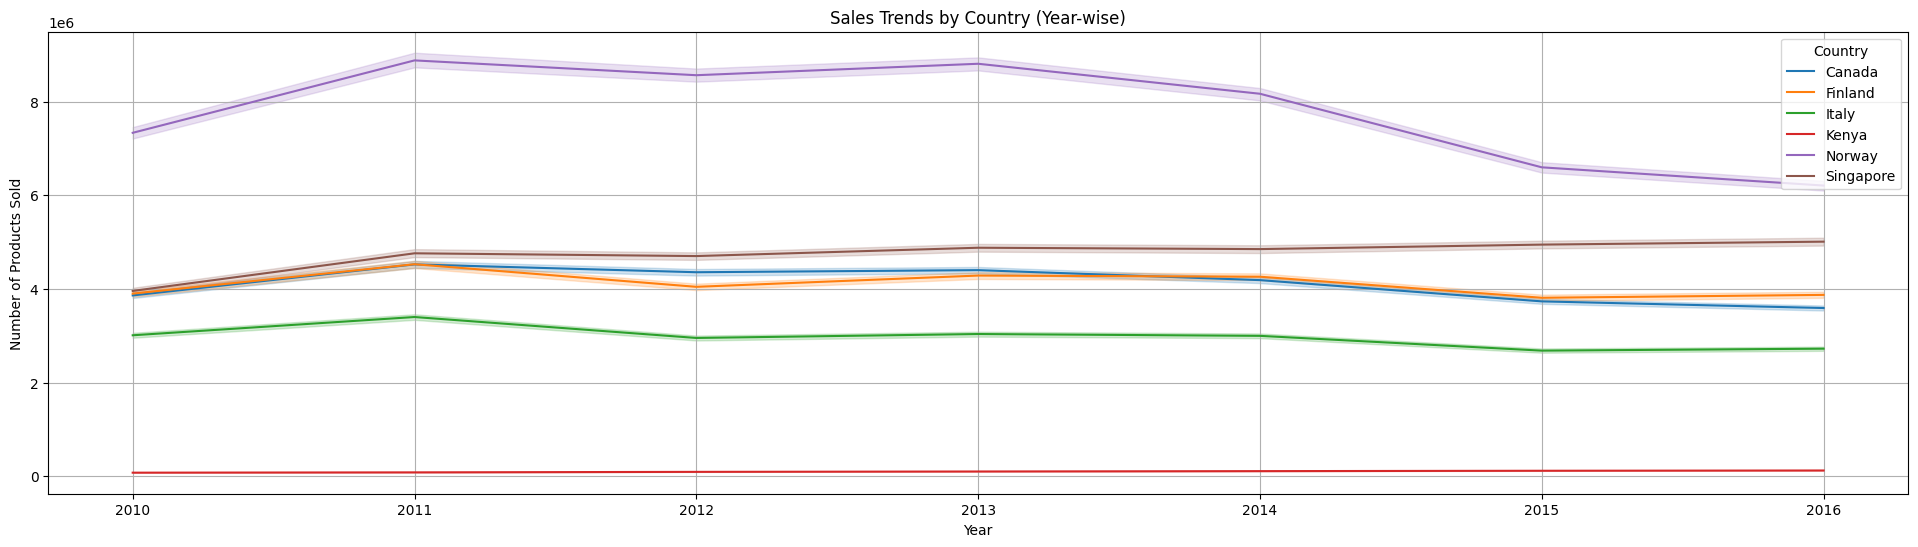

In [30]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=train['date'].dt.year, y=train['num_sold'], hue=train['country'], estimator='sum')
plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

In [31]:
agg_df_by_country = train.groupby(['date', 'country', 'product']).agg({'num_sold' : 'sum'}).reset_index().sort_values(['date', 'country', 'product'])
total_sales_by_country = agg_df_by_country.pivot(index='date',columns=['country', 'product'], values='num_sold')
total_sales_by_country.head()

country               Canada                                                   \
product    Holographic Goose  Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode   
date                                                                            
2010-01-01             675.0  5022.0       4578.0   2180.0             2644.0   
2010-01-02             617.0  5036.0       4348.0   2118.0             2722.0   
2010-01-03             635.0  5398.0       4547.0   2264.0             2770.0   
2010-01-04             512.0  3840.0       3419.0   1787.0             2265.0   
2010-01-05             527.0  3716.0       3549.0   1675.0             2038.0   

country              Finland                                                   \
product    Holographic Goose  Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode   
date                                                                            
2010-01-01             823.0  5178.0       4476.0   2436.0             2447.0   
2010-01-02             711.0  4639.0       4341.0   2107.0             2554.0   
2010-01-03             817.0  5341.0       4260.0   2364.0             2745.0   
2010-01-04             647.0  3828.0       3557.0   1808.0             2095.0   
2010-01-05             633.0  3926.0       3356.0   1626.0             2193.0   

country                Italy                                                   \
product    Holographic Goose  Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode   
date                                                                            
2010-01-01             607.0  3891.0       3342.0   1760.0             2045.0   
2010-01-02             584.0  3642.0       3060.0   1652.0             1950.0   
2010-01-03             624.0  3910.0       3546.0   1855.0             2080.0   
2010-01-04             491.0  2980.0       2747.0   1359.0             1568.0   
2010-01-05             482.0  3118.0       2632.0   1320.0             1618.0   

country                Kenya                                                  \
product    Holographic Goose Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode   
date                                                                           
2010-01-01              12.0  101.0         85.0     45.0               50.0   
2010-01-02              11.0   92.0         87.0     44.0               52.0   
2010-01-03              12.0  105.0         89.0     45.0               52.0   
2010-01-04               5.0   81.0         71.0     33.0               42.0   
2010-01-05               5.0   78.0         68.0     34.0               41.0   

country               Norway                                                   \
product    Holographic Goose  Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode   
date                                                                            
2010-01-01            1465.0  9001.0       8150.0   4348.0             4959.0   
2010-01-02            1392.0  9094.0       7774.0   4077.0             4841.0   
2010-01-03            1489.0  9820.0       8315.0   4372.0             5057.0   
2010-01-04            1169.0  7370.0       6856.0   3256.0             4115.0   
2010-01-05            1084.0  7076.0       6264.0   3291.0             3766.0   

country            Singapore                                                   
product    Holographic Goose  Kaggle Kaggle Tiers Kerneler Kerneler Dark Mode  
date                                                                           
2010-01-01             768.0  5032.0       4325.0   2291.0             2830.0  
2010-01-02             778.0  4942.0       4419.0   2201.0             2663.0  
2010-01-03             832.0  5033.0       4837.0   2315.0             2799.0  
2010-01-04             648.0  4069.0       3529.0   1777.0             2151.0  
2010-01-05             601.0  3672.0       3455.0   1740.0             2129.0

In [32]:
# train = train.drop(columns=['id', 'date'])
lencoder = LabelEncoder()

for col in ['country', 'store', 'product']:
    train[col] = lencoder.fit_transform(train[col])
    test[col] = lencoder.fit_transform(test[col])

train['num_sold'] = np.log1p(train['num_sold'])

train.head(10)
# test.head(10)

,id,date,country,store,product,num_sold,year,quarter,month,week,day,day_of_week,week_of_year,hour,minute,is_weekend,sine_day,cos_day,sine_month,cos_month,sine_year,cos_year,group
0,1,2010-01-01,0,0,1,6.881411,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
1,2,2010-01-01,0,0,2,6.810142,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
2,3,2010-01-01,0,0,3,6.049733,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
3,4,2010-01-01,0,0,4,6.198479,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
4,5,2010-01-01,0,2,0,5.707110,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
5,6,2010-01-01,0,2,1,7.516433,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
6,7,2010-01-01,0,2,2,7.414573,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
7,8,2010-01-01,0,2,3,6.694562,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
8,9,2010-01-01,0,2,4,6.846943,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
9,10,2010-01-01,0,1,0,5.929589,2010,1.0,1,53,1,4,53.0,0.0,0.0,0,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4


In [33]:
train = train.drop(columns=['date'], axis=1)
test = test.drop(columns=['date'], axis=1)

X = train.drop(columns=['num_sold'])
y = train['num_sold']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
xgb_model = xgb.XGBRegressor(
    n_estimators=3231,
    learning_rate=0.05895359669164567,
    max_depth=7,
    min_child_weight=4,
    subsample=0.8319649088461181,
    colsample_bytree=0.7107337151097438,
    gamma=0.0019772108405958213,
    reg_alpha=0.5384785820890761,
    reg_lambda=0.7912823880613118,
    objective='reg:squarederror',  # Correct regression objective
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist',  # Enable GPU for histograms
    predictor='gpu_predictor',  # Enable GPU for prediction
    eval_metric='mape'  # Set evaluation metric to MAPE
)

catboost_model = CatBoostRegressor(
    n_estimators=1891,
    learning_rate=0.06761514972690001,
    depth=8,
    min_data_in_leaf=54,
    l2_leaf_reg=5.567375613813537,
    bagging_temperature=0.15478395184586632,
    random_strength=0.9462614107298501,
    loss_function='MAPE',
    eval_metric='MAPE',
    random_state=42,
    early_stopping_rounds=50  # Specify the GPU device (use '0' for the first GPU, or '1' for the second GPU, etc.)
)

lgb_model = lgb.LGBMRegressor(
    n_estimators=3770,
    learning_rate=0.05038034487788465,
    max_depth=14,
    reg_alpha=0.20732364284443197,
    reg_lambda=0.004223724135505332,
    min_child_samples=29,
    colsample_bytree=0.6601202363535343,
    subsample=0.5597689123597346,
    objective='regression',  
    metric='mape',  
    n_jobs=-1,
    device='gpu'  # Enable GPU for LightGBM
)

meta_model = LinearRegression()

In [35]:
stacking_model = StackingRegressor(
    estimators=[('xgb1', xgb_model), ('xgb2', lgb_model), ('catboost', catboost_model)],
    final_estimator=meta_model,
    n_jobs=-1
)

stacking_model.fit(X, y)

StackingRegressor(estimators=[('xgb1',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7107337151097438,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mape',
                                            feature_types=None,
                                            gamma=0.0019772108405958213,
                                            grow_policy=None,
                                            importance_type=None,
                                            intera...
                                             device='gpu',
                                             learning_rate=0.05038034487788465,
                                             max_depth=14, metric='mape',
                                             min_child_samples=29,
                                             n_estimators=3770, n_jobs=-1,
                                             objective='regression',
                                             reg_alpha=0.20732364284443197,
                                             reg_lambda=0.004223724135505332,
                                             subsample=0.5597689123597346)),
                              ('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7b4a84914040>)],
                  final_estimator=LinearRegression(), n_jobs=-1)

In [36]:
submission_ids = test['id'] 
predictions = stacking_model.predict(test)

predictions = np.expm1(predictions)
# train.head(10)
# test.head(10)

In [37]:
submission = pd.DataFrame({
    'id': submission_ids,
    'num_sold': predictions 
})

submission.to_csv('submission5.csv', index=False)
print("File Saved!")
print(submission.head())

File Saved!
       id    num_sold
0  230130  138.786512
1  230131  868.440429
2  230132  696.296187
3  230133  386.269581
4  230134  456.003139


In [38]:
# # Prepare data for training
# X = train.drop(columns=['id', 'date', 'num_sold'])
# X = pd.get_dummies(X, drop_first=True)
# y = np.log1p(train['num_sold'])

# X_test = test.drop(columns=['id', 'date'])
# X_test = pd.get_dummies(X_test, drop_first=True)
# X_test = X_test.reindex(columns=X.columns, fill_value=0)

# from sklearn.model_selection import KFold
# from catboost import CatBoostRegressor

# # Initialize variables
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# train_predictions = np.zeros(len(train))
# mape_scores = []
# test_predictions_list = []

# # CatBoost Hyperparameters
# params = {
#     'iterations': 1000,             # Number of trees to build
#     'learning_rate': 0.1,           # Learning rate
#     'depth': 6,                     # Depth of the tree
#     'loss_function': 'MAPE',        # Loss function for regression
#     'cat_features': [],             # List of categorical features (if applicable)
#     'random_seed': 42,              # Random seed for reproducibility
#     'verbose': 200,                 # Print information every 200 iterations
# }


# # Train and validate model using 5-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # Train CatBoostRegressor
#     model = CatBoostRegressor(**params) #RandomForestRegressor(random_state=42, n_jobs=-1) #ExtraTreesRegressor(random_state=42, n_jobs=-1)  # #
#     model.fit(X_train, y_train)

#     # Make predictions
#     y_val_pred = model.predict(X_val)
#     train_predictions[val_idx] = y_val_pred

#     # Calculate MAPE
#     mape = mean_absolute_percentage_error(y_val, y_val_pred)
#     mape_scores.append(mape)
#     print(f"Fold {fold}: MAPE = {mape:.4f}")

#     # Predict on test data for this fold
#     test_pred_fold = model.predict(X_test)
#     test_predictions_list.append(test_pred_fold)

# # Average test predictions across folds
# test_predictions_avg = np.mean(test_predictions_list, axis=0)
# test_predictions_avg = np.expm1(test_predictions_avg) 

# # Print training MAPE score
# print(f"Training MAPE score (5-fold average): {np.mean(mape_scores):.4f}")

In [39]:
from sklearn.base import BaseEstimator, RegressorMixin
import contextlib, io
import ydf; ydf.verbose(2)
from ydf import GradientBoostedTreesLearner

def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [40]:
def build_model():
    
    x_input_cats = layers.Input(shape=(len(cat_features),))
    embs = []
    for j in range(len(cat_features)):
        e = layers.Embedding(t.cat_features_card[j], int(np.ceil(np.sqrt(t.cat_features_card[j]))))
        x = e(x_input_cats[:,j])
        x = layers.Flatten()(x)
        embs.append(x)
        
    x_input_nums = layers.Input(shape=(len(t.num_features),))
    
    x = layers.Concatenate(axis=-1)(embs+[x_input_nums]) 
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1)(x)
    
    model = keras.Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    return model

In [41]:
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor
# from sklearn.linear_model import RidgeClassifier, LogisticRegression, LinearRegression, Ridge, BayesianRidge
# from xgboost import DMatrix, XGBClassifier, XGBRegressor
# from lightgbm import log_evaluation, early_stopping, LGBMClassifier, LGBMRegressor, Dataset
# from catboost import CatBoostClassifier, CatBoostRegressor, Pool


# models = {
#     'NN': [_,
#            False],
#     'CAT': [CatBoostRegressor(**{'verbose': 0,
#                                  'random_state': 42,
#                                  'early_stopping_rounds': 200,
#                                  'eval_metric': "RMSE",
#                                  'n_estimators' : 2000,
#                                  'depth': 3,
#                                  'min_data_in_leaf': 96,
#                                  'l2_leaf_reg': 8.972890275248485,
#                                  'bagging_temperature': 0.18658249870341914, 
#                                  'random_strength': 0.14106593468982453,
#                                  'learning_rate': 0.01,
#                                 }),
#             False],
#     'CAT3': [CatBoostRegressor(**{'verbose': 0,
#                                   'random_state': 42,
#                                   'early_stopping_rounds': 200,
#                                   'eval_metric': "MAPE",
#                                   'n_estimators' : 2000,
#                                   'learning_rate': 0.01,
#                                   'depth': 8,
#                                   'min_data_in_leaf': 99,
#                                   'l2_leaf_reg': 7.7324870113971125, 
#                                   'bagging_temperature': 0.003232535109945575, 
#                                   'random_strength': 0.12145610701952099,
#                                  }),
#              False],
#     'CAT5': [CatBoostRegressor(**{'depth': 7,
#                                   'min_data_in_leaf': 59,
#                                   'l2_leaf_reg': 6.485681470975604, 
#                                   'bagging_temperature': 0.728613892125684,
#                                   'random_strength': 0.3565990691132947,
#                                   'verbose': 0,
#                                   'random_state': 42,
#                                   'early_stopping_rounds': 200,
#                                   'eval_metric': "MAPE",
#                                   'n_estimators' : 2000,
#                                   'learning_rate': 0.01,
#                                   "task_type": "GPU",
#                                  }),
#              False],
#     'CAT6': [CatBoostRegressor(**{'depth': 10,
#                                   'min_data_in_leaf': 67,
#                                   'l2_leaf_reg': 0.010658988402410939,
#                                   'bagging_temperature': 0.7381549501573549,
#                                   'random_strength': 0.10057316762567874,
#                                   'verbose': 0,
#                                   'random_state': 42,
#                                   'early_stopping_rounds': 200,
#                                   'eval_metric': "MAPE",
#                                   'n_estimators' : 2000,
#                                   'learning_rate': 0.01,
#                                   'bootstrap_type': 'Poisson',
#                                   "task_type": "GPU",
#                                  }),
#              False],
#     'XGB2': [XGBRegressor(**{'tree_method': 'hist',
#                              'n_estimators': 2000,
#                              'objective': 'reg:squarederror',
#                              'random_state': 42,
#                              'enable_categorical': True,
#                              'verbosity': 0,
#                              'early_stopping_rounds': 200,
#                              'eval_metric': 'rmse',
#                              'booster': 'gbtree', 
#                              'max_depth': 3,
#                              'min_child_weight': 16,
#                              'subsample': 0.8172380854733758, 
#                              'reg_alpha': 0.2734696712123178, 
#                              'reg_lambda': 0.5865768393479154,
#                              'colsample_bytree': 0.9766164536195251,
#                              'n_jobs': -1,
#                              'learning_rate': 0.01,
#                              'n_jobs': -1
#                             }),
#             False],
#     'XGB3': [XGBRegressor(**{'tree_method': 'hist',
#                              'n_estimators': 2000,
#                              'learning_rate': 0.01,
#                              'objective': 'reg:squarederror',
#                              'random_state': 42,
#                              'enable_categorical': True,
#                              'verbosity': 0,
#                              'early_stopping_rounds': 200,
#                              'eval_metric': 'mape',
#                              'booster': 'gbtree',
#                              'max_depth': 3,
#                              'min_child_weight': 12,
#                              'subsample': 0.7720667996291699, 
#                              'reg_alpha': 0.07869714859026081, 
#                              'reg_lambda': 0.9577219578640989, 
#                              'colsample_bytree': 0.9728085969282255, 
#                              'n_jobs': -1
#                            }),
#         False],
#     'XGB4': [XGBRegressor(**{'booster': 'gbtree',
#                              'max_depth': 3,
#                              'min_child_weight': 12,
#                              'subsample': 0.800221370346261,
#                              'reg_alpha': 0.4571249607822852,
#                              'reg_lambda': 0.6572354640280187,
#                              'colsample_bytree': 0.9982441671154363,
#                              'n_jobs': -1,
#                              'tree_method': 'hist',
#                              'n_estimators': 3000,
#                              'learning_rate': 0.01,
#                              'objective': 'reg:squarederror',
#                              'random_state': 42,
#                              'enable_categorical': True,
#                              'verbosity': 0,
#                              'early_stopping_rounds': 200,
#                              'eval_metric': 'mape',
#                              'booster': 'gbtree',
#                              "device": "cuda",
#                             }),
#              False],
#     'XGB5': [XGBRegressor(**{'booster': 'gbtree',
#                              'max_depth': 3,
#                              'min_child_weight': 19,
#                              'subsample': 0.8065343833518619,
#                              'reg_alpha': 0.3577049940509907,
#                              'reg_lambda': 0.8560297700871249,
#                              'colsample_bytree': 0.9866141987520272,
#                              'objective': 'reg:squarederror',
#                              'n_jobs': -1,
#                              'tree_method': 'hist',
#                              'n_estimators': 3000,
#                              'learning_rate': 0.01,
#                              'random_state': 42,
#                              'enable_categorical': True,
#                              'verbosity': 0,
#                              'early_stopping_rounds': 200,
#                              'eval_metric': 'mape', 
#                              "device": "cuda",
#                              }),
#              False],
#     'LGBM2': [LGBMRegressor(**{'random_state': 42,
#                                'early_stopping_round': 200,
#                                'verbose': -1,
#                                'boosting_type': 'gbdt',
#                                'eval_metric': 'rmse',
#                                'objective': 'regression_l2',
#                                'n_estimators': 5000,
#                                'max_depth': 13, 
#                                'num_leaves': 891, 
#                                'min_child_samples': 16,
#                                'min_child_weight': 11,
#                                'colsample_bytree': 0.48639630433139497,
#                                'reg_alpha': 0.45496760242817474,
#                                'reg_lambda': 0.9669296995303693,
#                                'learning_rate': 0.01
#                               }),
#              False],
#     'LGBM3': [LGBMRegressor(**{'random_state': 42,
#                                'early_stopping_round': 200,
#                                'verbose': -1,
#                                'boosting_type': 'gbdt',
#                                'eval_metric': 'rmse',
#                                'objective': 'regression_l2',
#                                'n_estimators': 2000,
#                                'max_depth': 6, 
#                                'num_leaves': 328,
#                                'min_child_samples': 10,
#                                'min_child_weight': 16,
#                                'colsample_bytree': 0.4893394195489041,
#                                'reg_alpha': 0.18334253987924942,
#                                'reg_lambda': 0.8328414321738785,
#                                'learning_rate': 0.01
#                               }),
#              False],
#     'LGBM4': [LGBMRegressor(**{'objective': 'regression_l2',
#                                'metric': 'mape', 
#                                'max_depth': 12, 
#                                'num_leaves': 878,
#                                'min_child_samples': 29,
#                                'min_child_weight': 14,
#                                'colsample_bytree': 0.49788260207319734, 
#                                'reg_alpha': 0.4747476308475839, 
#                                'reg_lambda': 0.6960820486441526,
#                                'random_state': 42,
#                                'early_stopping_round': 200,
#                                'verbose': -1,
#                                'boosting_type': 'gbdt',
#                                'eval_metric': 'mape',
#                                'objective': 'regression_l2',
#                                'n_estimators': 3000,
#                                'learning_rate': 0.01,
#                                }),
#               False],
#     'LGBM5': [LGBMRegressor(**{'objective': 'regression_l2',
#                                'metric': 'mape', 
#                                'max_depth': 7,
#                                'num_leaves': 123, 
#                                'min_child_samples': 21,
#                                'min_child_weight': 24,
#                                'colsample_bytree': 0.3641261996760593, 
#                                'reg_alpha': 0.03632800166349373, 
#                                'reg_lambda': 0.5287861861476272,
#                                'random_state': 42,
#                                'early_stopping_round': 200,
#                                'verbose': -1,
#                                'boosting_type': 'gbdt',
#                                'n_estimators': 3000,
#                                'learning_rate': 0.01,
#                                }),
#               False],
#     'LGBM6': [LGBMRegressor(**{'objective': 'regression_l2',
#                                'metric': 'mape',
#                                'max_depth': 6,
#                                'num_leaves': 502,
#                                'min_child_samples': 23,
#                                'min_child_weight': 18, 
#                                'colsample_bytree': 0.4714820876493163, 
#                                'reg_alpha': 0.054972003081022576, 
#                                'reg_lambda': 0.5774608955362155,
#                                'random_state': 42,
#                                'early_stopping_round': 200,
#                                'verbose': -1,
#                                'boosting_type': 'goss',
#                                'n_estimators': 3000,
#                                'learning_rate': 0.01,
#                               }),
#              False],
#     'LGBM7': [LGBMRegressor(**{'objective': 'regression_l2', 
#                                'metric': 'mape',
#                                'max_depth': 14,
#                                'num_leaves': 279,
#                                'min_child_samples': 7,
#                                'min_child_weight': 24, 
#                                'colsample_bytree': 0.43218993309765835,
#                                'reg_alpha': 0.42757392987472964,
#                                'reg_lambda': 0.9039762787446107,
#                                'random_state': 42,
#                                'early_stopping_round': 200,
#                                'verbose': -1,
#                                'boosting_type': 'goss',
#                                'n_estimators': 3000,
#                                'learning_rate': 0.01,
#                                }),
#               False],
#     'Ridge': [Ridge(tol=1e-2, max_iter=1000000,
#                     random_state=42),
#               False],
#     'BRidge': [BayesianRidge(tol=1e-2, n_iter=1000000),
#               False],
#     'LR': [LinearRegression(),
#               False],
#     'HGB': [HistGradientBoostingRegressor(**{'max_depth': 4,
#                                              'loss': 'squared_error',
#                                              'l2_regularization': 0.014082438341668873,
#                                              'min_samples_leaf': 39,
#                                              'max_leaf_nodes': 25,
#                                              'learning_rate': 0.01,
#                                              'max_iter': 2000,
#                                              'random_state': 42,
#                                              'early_stopping': 200,
#                                             }),
#               False],
#     'HGB2': [HistGradientBoostingRegressor(**{'max_depth': 4,
#                                               'loss': 'squared_error',
#                                               'l2_regularization': 1.0294569289519551e-05,
#                                               'min_samples_leaf': 12, 
#                                               'max_leaf_nodes': 26,
#                                               'learning_rate': 0.01,
#                                               'max_iter': 2000,
#                                               'random_state': 42,
#                                               'early_stopping': 200,
#                                              }),
#              False],
#     'HGB3': [HistGradientBoostingRegressor(**{'max_depth': 13, 
#                                               'loss': 'squared_error',
#                                               'l2_regularization': 0.05253480068908677,
#                                               'min_samples_leaf': 19,
#                                               'max_leaf_nodes': 40,
#                                               'learning_rate': 0.01,
#                                               'max_iter': 3000,
#                                               'random_state': 42,
#                                               'early_stopping': 200,
#                                              }),
#              False],
#     'HGB4': [HistGradientBoostingRegressor(**{'max_depth': 4, 
#                                               'loss': 'squared_error', 
#                                               'l2_regularization': 1.3248236291502028e-09,
#                                               'min_samples_leaf': 39,
#                                               'max_leaf_nodes': 29,
#                                               'learning_rate': 0.01,
#                                               'max_iter': 3000,
#                                               'random_state': 42,
#                                               'early_stopping': 200,
#                                              }),
#              False],
#     'YDF': [YDFRegressor(GradientBoostedTreesLearner)({'num_trees': 1000,
#                                                        'max_depth': 13,
#                                                        }),
#             False]
# }

In [42]:
# model = Model(X, X_enc, y, test, test_enc, models)
# TEST_preds = model.train()

In [43]:
# test['predicted_num_sold'] = test_predictions_avg
# print(test[['id', 'predicted_num_sold']])

# test[['id', 'predicted_num_sold']].to_csv('submission.csv', index=False)